# Calculate the relative performance of each algorithm over all datasets

Both the ranking and the normalized performance.

In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import display_html

from metadata_utils import get_metadata, get_tuned_alg_perf, process_metafeatures, compute_feature_corrs

In [2]:
dataset_version = "_v1"

# For choosing metafeatures
filter_families = [
    'general',
    'statistical',
    'info-theory'
]

metadataset_df, metafeatures_df = get_metadata(dataset_version)

metafeatures_processed = process_metafeatures(metafeatures_df, filter_families=filter_families)
metafeatures_df = metafeatures_processed



/home/shared/tabzilla/tabzilla_analysis/metadata_utils.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metafeatures_processed = metafeatures_df.fillna(metafeatures_df.median())


# Get tuned algorithms for a given metric

Report the average & median test performance, over all folds. Note that each alg is tuned for each fold separately.

In [3]:
metric_list = [
    "Log Loss",
    "F1",
    "Accuracy",
]

obj_type_list = [
    "minimize",
    "maximize",
    "maximize",
]
result_df_dict = {}



In [4]:
for metric, objective_type in zip(metric_list, obj_type_list):

    test_metric_col = metric + "__test"

    tuned_alg_perf = get_tuned_alg_perf(metadataset_df, metric=metric)
    # NOTE: this "tunes" each algorithm for each training fold separately. so each of the 10 folds might use different hparams.

    # make sure there are at most 10 rows for each alg-dataset pair (one row per split)
    print("max number of rows for each tuned alg-dataset pair:")
    print(tuned_alg_perf.groupby(["alg_name", "dataset_name"])["dataset_name"].count().max())

    # aggregate over folds: take the mean & median performance over each fold
    agg_tuned_alg_perf = tuned_alg_perf.groupby(["alg_name", "dataset_name"]).agg(
        {
            test_metric_col: ["median", "mean"],
            "time__train": ["median", "mean"],
        }
    ).reset_index()

    # rename the multiindex cols
    new_cols = []
    for c in agg_tuned_alg_perf.columns:
        if c[1] == "":
            new_cols.append(c[0])
        else:
            new_cols.append("_".join(c))

    agg_tuned_alg_perf.columns = new_cols


    # define the target metric column, we will use this value for all plots
    result_col = test_metric_col + "_mean"

    # for each dataset, find the min and max metrics over all tuned algs
    overall_bounds = agg_tuned_alg_perf.groupby("dataset_name").agg({result_col: ["min", "max"]}).reset_index()

    # rename the multiindex cols
    new_cols = []
    for c in overall_bounds.columns:
        if c[1] == "":
            new_cols.append(c[0])
        else:
            new_cols.append("_".join(c))

    overall_bounds.columns = new_cols

    agg_tuned_alg_perf = agg_tuned_alg_perf.merge(overall_bounds, on="dataset_name", how="left")

    # add normalized metric
    agg_tuned_alg_perf.loc[:, "normalized_" + result_col] = (agg_tuned_alg_perf[result_col] - agg_tuned_alg_perf[result_col + "_min"]) / (agg_tuned_alg_perf[result_col + "_max"] - agg_tuned_alg_perf[result_col + "_min"])

    # rank all algs for each dataset
    ascending = False if objective_type == "maximize" else True
    
    # choose the mean or median
    for agg_method in ["mean", "median"]:
        agg_tuned_alg_perf.loc[:, "metric_rank" + "_" + agg_method] = agg_tuned_alg_perf.groupby(["dataset_name"])[test_metric_col + "_" + agg_method].rank(method="min", ascending=ascending).values

    result_df_dict[metric] = agg_tuned_alg_perf.copy()

max number of rows for each tuned alg-dataset pair:
10
max number of rows for each tuned alg-dataset pair:
10
max number of rows for each tuned alg-dataset pair:
10


In [5]:
# sanity check..
result_df_dict["Accuracy"][result_df_dict["Accuracy"]["dataset_name"] == "openml__Amazon_employee_access__34539"]

,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,Accuracy__test_mean_min,Accuracy__test_mean_max,normalized_Accuracy__test_mean,metric_rank_mean,metric_rank_median
1,CatBoost,openml__Amazon_employee_access__34539,0.946903,0.947359,1.708439,1.729567,0.941957,0.95157,0.561901,3.0,2.0
98,DecisionTree,openml__Amazon_employee_access__34539,0.942316,0.942232,0.284152,0.344668,0.941957,0.95157,0.028573,6.0,5.0
205,KNN,openml__Amazon_employee_access__34539,0.942020,0.941957,0.140002,0.135941,0.941957,0.95157,0.000000,10.0,7.0
303,LightGBM,openml__Amazon_employee_access__34539,0.951022,0.951570,4.414482,3.945315,0.941957,0.95157,1.000000,1.0,1.0
401,LinearModel,openml__Amazon_employee_access__34539,0.942020,0.942110,0.154202,0.170204,0.941957,0.95157,0.015875,7.0,7.0
501,MLP,openml__Amazon_employee_access__34539,0.942020,0.942049,64.320210,63.266802,0.941957,0.95157,0.009526,9.0,7.0
607,RandomForest,openml__Amazon_employee_access__34539,0.943851,0.944002,2.977825,2.553213,0.941957,0.95157,0.212693,4.0,4.0
793,TabNet,openml__Amazon_employee_access__34539,0.942173,0.942537,156.417203,205.212617,0.941957,0.95157,0.060315,5.0,6.0
896,VIME,openml__Amazon_employee_access__34539,0.942020,0.942110,86.552236,87.757028,0.941957,0.95157,0.015875,7.0,7.0
993,XGBoost,openml__Amazon_employee_access__34539,0.946742,0.947786,0.821818,0.870703,0.941957,0.95157,0.606338,2.0,3.0


# Aggregate results

In [6]:
# best, worst, and average performance for each alg, over all datasets
for metric in metric_list:

    overall_ranks = result_df_dict[metric].groupby("alg_name").agg(
        {
            "metric_rank_mean": ["min", "max", "mean", "count"],
        }
    ).reset_index().sort_values([("metric_rank_mean", "mean")])
    print(f"metric: {metric}")
    print(overall_ranks)

    # save to csv
    overall_ranks.to_csv(f"./results/rank_tables_{metric}.csv", index=False)

    print("\n")

metric: Log Loss
        alg_name metric_rank_mean                      
                              min   max      mean count
10       XGBoost              1.0   7.0  2.371429   105
0       CatBoost              1.0   7.0  3.000000    97
3       LightGBM              1.0  10.0  3.163265    98
7            SVM              1.0  10.0  4.444444    81
8         TabNet              1.0  11.0  5.650485   103
6   RandomForest              1.0  10.0  5.790476   105
4    LinearModel              1.0  11.0  6.660000   100
5            MLP              1.0  11.0  7.028302   106
9           VIME              1.0  11.0  7.979381    97
1   DecisionTree              2.0  11.0  8.149533   107
2            KNN              2.0  11.0  8.459184    98


metric: F1
        alg_name metric_rank_mean                      
                              min   max      mean count
10       XGBoost              1.0  10.0  3.161905   105
0       CatBoost              1.0  10.0  3.536082    97
3       LightGBM  

## spaghetti plot - relative performance over different datasets.

In [132]:
# which datasets to use?

result_df_dict["F1"][(result_df_dict["F1"]["alg_name"] == "CatBoost") & (result_df_dict["F1"]["metric_rank_mean"] < 2)]

,alg_name,dataset_name,F1__test_median,F1__test_mean,time__train_median,time__train_mean,F1__test_mean_min,F1__test_mean_max,normalized_F1__test_mean,metric_rank_mean,metric_rank_median
2,CatBoost,openml__Australian__146818,0.869565,0.872464,1.347650,1.393643,0.711594,0.872464,1.0,1.0,1.0
13,CatBoost,openml__albert__189356,0.703379,0.704762,33.092527,35.153920,0.563360,0.704762,1.0,1.0,1.0
19,CatBoost,openml__bank-marketing__9899,0.890609,0.896706,1.097164,1.289392,0.883434,0.896706,1.0,1.0,4.0
23,CatBoost,openml__breast-cancer__145799,0.750000,0.765764,0.860736,0.948556,0.671429,0.765764,1.0,1.0,2.0
24,CatBoost,openml__breast-w__15,0.971429,0.971366,0.670260,0.687874,0.951346,0.971366,1.0,1.0,1.0
27,CatBoost,openml__churn__167141,0.956000,0.958000,2.666251,2.517326,0.859600,0.958000,1.0,1.0,2.0
32,CatBoost,openml__credit-approval__29,0.884058,0.875362,1.388361,1.517310,0.681159,0.875362,1.0,1.0,1.0
38,CatBoost,openml__dresses-sales__125920,0.630000,0.620000,0.774950,1.060216,0.542000,0.620000,1.0,1.0,1.0
42,CatBoost,openml__eucalyptus__2079,0.666711,0.660875,1.438742,3.717244,0.359997,0.660875,1.0,1.0,1.0
53,CatBoost,openml__jasmine__168911,0.817423,0.816006,1.930358,2.099163,0.780486,0.816006,1.0,1.0,1.0


In [ ]:
# openml__diabetes__37 <-- lm does well
# openml__isolet__3481
# openml__haberman__42
# openml__robert__168332

# openml__soybean__41 <-- rf does well
# openml__vowel__3022
# openml__guillermo__168337

# openml__cmc__23 <-- mlp does well
# openml__CIFAR_10__167124
# openml__Fashion-MNIST__146825
# openml__Internet-Advertisements__167125	
# openml__dilbert__168909

# openml__Australian__146818 <-- catboost
# openml__APSFailure__168868
# openml__wdbc__9946
# openml__pc1__3918
# openml__eucalyptus__2079

In [181]:
plot_datasets = [
    "openml__diabetes__37",  # <-- lm does well
    "openml__isolet__3481",
    "openml__haberman__42",
    # "openml__robert__168332", # not enough successful algs
    "openml__soybean__41", #  <-- rf does well
    "openml__vowel__3022",
    # "openml__guillermo__168337", # not enough successful algs
    "openml__cmc__23", # <-- mlp does well
    # "openml__CIFAR_10__167124",  # not enough successful algs
    # "openml__Fashion-MNIST__146825",  # not enough successful algs
    "openml__Internet-Advertisements__167125",	
    "openml__dilbert__168909",
    "openml__Australian__146818",  #<-- catboost
    "openml__APSFailure__168868",
    "openml__wdbc__9946",
    "openml__pc1__3918",
    "openml__eucalyptus__2079",
]

# names to show on the plot
plot_dataset_names = [name[len("openml__"):].split("_")[0] for name in plot_datasets]

In [182]:
# number of results for each dataset
num_alg_per_dataset = result_df_dict["F1"].groupby("dataset_name")["alg_name"].count()
num_alg_per_dataset[num_alg_per_dataset < 10].sort_values()

dataset_name
openml__Devnagari-Script__167121                          5
openml__covertype__7593                                   5
openml__helena__168329                                    5
openml__CIFAR_10__167124                                  6
openml__albert__189356                                    6
openml__guillermo__168337                                 6
openml__Fashion-MNIST__146825                             7
openml__riccardo__168338                                  7
openml__robert__168332                                    7
openml__airlines__189354                                  8
openml__mnist_784__3573                                   8
openml__higgs__146606                                     9
openml__jungle_chess_2pcs_raw_endgame_complete__167119    9
openml__numerai28.6__167120                               9
openml__skin-segmentation__9965                           9
openml__sylvine__168912                                   9
Name: alg_name, dtype: int6

In [183]:
plot_algs = agg_tuned_alg_perf["alg_name"].unique()

# gather data for the spaghetti plot
data = dict()
for i_metric, metric_name in enumerate(metric_list):
    data[metric_name] = dict()
    for alg in plot_algs:
            data[metric_name][alg] = []
            for dataset in plot_datasets:
                vals = result_df_dict[metric].loc[(result_df_dict[metric]["alg_name"] == alg) & (result_df_dict[metric]["dataset_name"] == dataset), f"normalized_{metric}__test_mean"].values
                if len(vals) != 1:
                    print(f"there's an issue with {alg}-{dataset}-{metric_name}")
                    print(vals)
                    val = None
                else:
                    val = vals[0]
                data[metric_name][alg].append(val)
        

there's an issue with CatBoost-openml__isolet__3481-Log Loss
[]
there's an issue with LightGBM-openml__dilbert__168909-Log Loss
[]
there's an issue with RandomForest-openml__haberman__42-Log Loss
[]
there's an issue with SVM-openml__soybean__41-Log Loss
[]
there's an issue with CatBoost-openml__isolet__3481-F1
[]
there's an issue with LightGBM-openml__dilbert__168909-F1
[]
there's an issue with RandomForest-openml__haberman__42-F1
[]
there's an issue with SVM-openml__soybean__41-F1
[]
there's an issue with CatBoost-openml__isolet__3481-Accuracy
[]
there's an issue with LightGBM-openml__dilbert__168909-Accuracy
[]
there's an issue with RandomForest-openml__haberman__42-Accuracy
[]
there's an issue with SVM-openml__soybean__41-Accuracy
[]


In [184]:
### plotting kwargs

plot_alg_map = {
    "XGBoost": {
        "name": "XGBoost",
        "plt-kwargs": {"marker":"x", "color":"r", "linestyle":"--"}
    },
    "CatBoost": {
        "name": "CatBoost",
        "plt-kwargs": {"marker":"+", "color":"r", "linestyle":"--"}
    },
    "LightGBM": {
        "name": "LightGBM",
        "plt-kwargs": {"marker":"d", "color":"r", "linestyle":"--"}
    },
    "SVM": {
        "name": "SVM",
        "plt-kwargs": {"marker":"v", "color":"black", "linestyle":"-"}
    },
    "KNN": {
        "name": "KNN",
        "plt-kwargs": {"marker":"^", "color":"black", "linestyle":"-"}
    },
    "DecisionTree": {
        "name": "DecisionTree",
        "plt-kwargs": {"marker":">", "color":"black", "linestyle":"-"}
    },
    "RandomForest": {
        "name": "RandomForest",
        "plt-kwargs": {"marker":"P", "color":"black", "linestyle":"-"}
    },
    "LinearModel": {
        "name": "LinearModel",
        "plt-kwargs": {"marker":"<", "color":"black", "linestyle":"-"}
    },
    "TabNet": {
        "name": "TabNet",
        "plt-kwargs": {"marker":"X", "color":"b", "linestyle":":"}
    },
    "MLP": {
        "name": "MLP",
        "plt-kwargs": {"marker":"o", "color":"b", "linestyle":":"}
    },
    "VIME": {
        "name": "VIME",
        "plt-kwargs": {"marker":"P", "color":"b", "linestyle":":"}
    },
}

plot_algs = plot_alg_map.keys()

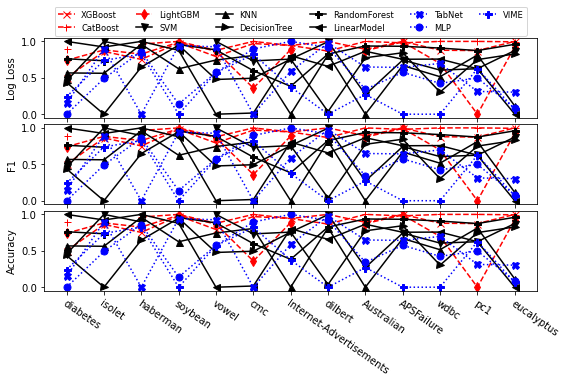

In [185]:
import numpy as np
fig, ax = plt.subplots(len(metric_list), 1, sharex=True, figsize=(8, 5))

for i, metric in enumerate(metric_list):
    for alg in plot_algs:    
        ax[i].plot(data[metric][alg], label=alg, markersize=7, **plot_alg_map[alg]["plt-kwargs"])
    ax[i].set_ylabel(metric)

    ax[i].set_xticks(np.arange(len(plot_dataset_names)))
    ax[i].set_xticklabels(plot_dataset_names, rotation=-35, ha='left', rotation_mode='anchor')

plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 3.6), ncol=6, fontsize="small")
plt.show()
# plt.savefig("./fig/squiggly.pdf", bbox_inches='tight')
